# <center> **Задача кластеризации:**
## <center> Сегментация клиентов онлайн магазина подарков

Импорт базовых библиотек:

In [1]:
# Основные
import pandas as pd
import numpy as np

# Машинное обучение
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score

# Статистические тесты
from scipy.stats import shapiro

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Предупреждения
import warnings 

warnings.filterwarnings("ignore")
plt.style.use('bmh')
plt.rcParams["patch.force_edgecolor"] = True

## 1. Знакомство со структурой данных

Первым делом необходимо понять, с какими данными предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

In [2]:
data = pd.read_csv("data/pj6_data.zip", 
                   encoding="ISO-8859-1", 
                   dtype={'CustomerID': str,'InvoiceID': str})

data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France


### 1.1 Основная информация

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


> В данных довольно мало числовых признаков. Пропуски присутствуют в 2 столбцах. 

### 1.2 Статистические характеристики

In [4]:
data.describe(include='object')

,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country
count,541909,541909,540455,541909,406829,541909
unique,25900,4070,4223,23260,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,17841,United Kingdom
freq,1114,2313,2369,1114,7983,495478


In [5]:
data.describe(exclude='object').round(2)

,Quantity,UnitPrice
count,541909.00,541909.00
mean,9.55,4.61
std,218.08,96.76
min,-80995.00,-11062.06
25%,1.00,1.25
50%,3.00,2.08
75%,10.00,4.13
max,80995.00,38970.00


> Из более чем 500,000 записей найдено 4372 уникальных клиента. Представлено 38 стран, но подавляющее большинство записей занимает Великобритания. В признаках о количестве товара и цены за единицу присутствуют отрицательные значения, причем максимальное и минимальное количество - одно и то же, только со знаками плюс и минус. 

### 1.3 Какие страны есть в данных?

In [6]:
data['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

> Среди стран есть такие значения как `"unspecified"`, их можно считать пропусками.

### 1.4 Идентификатор клиента 

In [7]:
data['CustomerID'].apply(lambda x: ((not str(x).isnumeric()) and 
                                    (x is not np.nan))).sum()

0

> Идентификатор клиента имеет тип данных `'object'`, но состоит только из цифр.

### 1.5 Пропуски и дубликаты

In [8]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
data[data.duplicated()].shape[0]

5268

> Присутствует довольно большое количество пропусков в столбце `'CusromerID'` и еще в `'Description'`. Также есть дубликаты, их относительно немного.

### 1.6 Перевод признаков в корректные форматы

In [10]:
# Преобразуем идентификатор клиента в числовой формат
data['CustomerID'] = data['CustomerID'].astype(float)

# Узнаем в каком временном интервале проводились транзакции
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

print('Date interval {} to {}'.format(data['InvoiceDate'].dt.date.min(), 
                                      data['InvoiceDate'].dt.date.max()))

Date interval 2010-12-01 to 2011-12-09


> Данные были собраны примерно за 1 год работы магазина. 

## 2. Преобразование, очистка и анализ данных

### 2.1. Преобразование и очистка данных о транзакциях

#### 2.1.1 Пропуски

Пропуски в столбце с идентификатором клиента (CustomerID) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалим их из данных.

**Примечание.** Если посмотреть на распределение пропусков в столбцах Description и CustomerID, то можно заметить, что достаточно удалить строки, содержащие пропуски в столбце CustomerID, тогда пропуски в столбце Description удаляются автоматически.


In [11]:
# Я сделаю так. Узнаем какие строки в данных не содержат пропуски в этом столбце, 
# а затем наложим маску на все данные. Как показывает результат, пропусков в данных больше нет. 

notnull_rows = data['CustomerID'].notnull()
data = data[notnull_rows]

print(data.isna().sum(), '\n')
print(data.shape)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64 

(406829, 8)


#### 2.1.2. Дубликаты

Проверьте данные на наличие дубликатов. Удалим их из данных.


In [12]:
# Дубликаты в данных есть. Найдем их индексы и удалим их с помощью метода .drop
# После этого дубликатов в данных нет.

data.drop_duplicates(inplace=True)

print(data.duplicated().sum(), '\n')
print(data.shape)

0 

(401604, 8)


#### 2.1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [13]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()

nb_products_per_basket = temp.rename(columns={'InvoiceDate': 'Number of products'})

nb_products_per_basket

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
...,...,...,...
22185,18283.0,579673,50
22186,18283.0,580872,50
22187,18287.0,554065,29
22188,18287.0,570715,38


**Примечание.** Более 16 % уникальных заказов являются возвратами. 

**Интересный факт:** если мы подсчитали количество транзакций, содержащих признак возврата, в изначальной таблице, где на каждый уникальный товар заведена отдельная строка, то мы получили бы, что количество возвратов менее 1 %. Однако это число было бы некорректным.

Создадим в наших данных о транзакциях признак `QuantityCanceled`. Этот признак будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом. Для транзакций, для которых не было возвратов, признак будет равен 0. Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым.

В качестве вспомогательного инструмента я подготовил функцию `get_quantity_canceled()`. Эта функция принимает на вход таблицу с транзакциями и возвращает объект `Series` — столбец, в котором указано количество отменённого впоследствии товара для каждой транзакции. Если транзакция не имеет контрагента, этот признак помечается как `NaN`.

In [14]:
def get_quantity_canceled(data: pd.DataFrame) -> pd.Series:
    """Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано 
    количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция c отрицательным количеством товара не имеет контрагента, 
    данный признак помечается как NaN.

    Args:
    -
        data (DataFrame): таблица c транзакциями

    Returns:
    -
        Series: столбец c количеством отменённого товара
    """
    
    # Инициализируем Series с нулями той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    
    # Какие строки в таблице содержат отрицательное количество товара
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        
        # Транзация-возврат не имеет контрагента — 
        # помечаем столбец как пропуск
        if df_test.shape[0] == 0: 
            quantity_canceled.loc[index] = np.nan
            
        # Транзакция-возврат имеет ровно одного контрагента — 
        # добавляем количество отменённого товара в столбец QuantityCanceled 
        elif df_test.shape[0] == 1: 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity'] 
                  
        # Транзакция-возврат имеет несколько контрагентов — 
        # Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара больше количества товаров в транзакции-возврате.
        else: 
            df_test.sort_index(axis=0, 
                               ascending=False, 
                               inplace=True)  
                  
            for i, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[i] = -col['Quantity']
                break         
            
    return quantity_canceled


data['QuantityCanceled'] = get_quantity_canceled(data)

data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0.0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0.0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0


> Поскольку данных очень много, код выполняется в среднем 5-6 минут.

Транзакции, которые не имеют контрагентов, если их количество невелико, мы удалим из данных. Также удалим и транзакции с отрицательным количеством товара — они нам больше не нужны.

In [15]:
# Действительно, таких транзакций не так много в данных (помечены пропуском).
# Отфильтруем их и обновим данные.

data = data[data['QuantityCanceled'].notnull()]

data.query('Quantity >= 0', inplace=True)

data.shape

(392732, 9)

#### 2.1.4. Специализированные транзакции

Следующая задача — обработать специальные виды транзакций, которые обозначаются латинскими буквами.

В данных присутствует шесть специальных видов транзакций. С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

Чтобы понять, что означают эти коды, можно заглянуть в столбец с описанием (Description), например POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.

Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны. Удалим все специальные транзакции из таблицы.

In [16]:
# Я решил не мудрить с регулярными выражениями и сделал проще. 
# Найдем такие коды товаров, где первый символ - латинская буква, получилась маска. 
# Затем наложим ее на данные, найдем индексы получившихся значений и удалим эти строки.

spec_operations = data['StockCode'].apply(lambda x: x[0].isalpha())
spec_rows = data[spec_operations].index

data.drop(spec_rows, axis=0, inplace=True)

data.shape

(391183, 9)

#### 2.1.5. Транзакции с товарами без стоимости

При просмотре описательных статистик можно заметить, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций оказывается менее 1 % — можно удалить их.

In [17]:
# Отфильтруем данные так, чтобы в них не было нулевой стоимости.

data.query('UnitPrice != 0', inplace=True)

data.shape

(391150, 9)

#### 2.1.6. Общая стоимость товаров в транзакции

Добавьте в ваш датасет общую цену заказа (TotalPrice). Она рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Этот признак впоследствии поможет вам рассчитать покупательскую способность каждого из клиентов.

In [18]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34


#### 2.1.7 Транзакции с неуказанной страной

У некоторых транзакций по тем или иным причинам невозможно узнать страну. Такие данные можно считать пропусками, их также очень немного, поэтому удалим их.

In [19]:
data.query('Country != "Unspecified"', inplace=True)

data.shape

(390909, 10)

#### 2.1.8 Является ли покупатель частым?

Постоянные покупатели - важная категория клиентов, поэтому нам нужно ее выделить из данных.

In [20]:
# Создадим признак-флаг, часто ли данный клиент делает транзакции. 
# Если больше 500 раз - то клиент частый, иначе - 0. 

cust_vc = data['CustomerID'].value_counts()
cust_frequent = cust_vc[cust_vc >= 500].index.tolist()

data['IsFrequentCustomer'] = data['CustomerID'].apply(lambda x: 1 if x in cust_frequent else 0)

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,IsFrequentCustomer
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0.0,15.30,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0.0,22.00,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,0


#### 2.1.9 Признаки даты и времени

Дата и время могут дать много информации о покупателях. Так что лучше выделить из него только конкретные моменты, которые могут сказать больше всего информации. К примеру, месяц, день и день недели могут подтвердить гипотезу о том, что больше всего покупок происходит в праздники или по выходным.

In [21]:
# Выделим важные моменты даты и времени

data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,IsFrequentCustomer,Month,Day,DayOfWeek
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0.0,15.30,0,12,1,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,0,12,1,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0.0,22.00,0,12,1,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,0,12,1,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,0,12,1,2


#### 2.1.10 Обработка названий товаров

Немаловажно для сегментации клиентов - категории товаров, которые они покупают. Я решил выделить те, которые пользуются наиболшей популярностью и занести их в отдельный список. Затем создать флаг, который указывает, покупает ли конкретный клиент товар из этого списка. 

In [22]:
# Выделим товары, которые купили более 500 раз. 
# Занесем слова из их названий во множество, чтобы получить список с уникальными значениями.
# А затем избавим этот список от чисел и других "шумовых" элементов.

descr_vc = data['Description'].value_counts()
descr_freq = descr_vc[descr_vc >= 500].index.tolist()

catset = set()

for cat in descr_freq:
    cats = cat.split()
    for c in cats:
        catset.add(c)
        
catlist = list(filter(lambda x: True if ((x.isalpha()) and (len(x) > 2)) else False, 
                      catset))

# Первые 20 элементов списка
catlist[:20]

['DESIGN',
 'COME',
 'GARDENERS',
 'GINGERBREAD',
 'HARMONICA',
 'SCOTTIE',
 'HAND',
 'CLOCK',
 'SLATE',
 'ASSORTED',
 'GREEN',
 'JAM',
 'POLKADOT',
 'BUNTING',
 'WATER',
 'CHARLOTTE',
 'ANIMALS',
 'NEW',
 'CHOCOLATE',
 'PAD']

In [23]:
# Пройдемся по столбцу с названиями товаров с помощью функции,
# которая проверяет, есть ли в них слова из списка с категориями.

def catbin(x):
    for cat in x.split():
        if cat in catlist:
            return 1
        else:
            return 0

data['IsFrequentStock'] = data['Description'].apply(catbin)

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,IsFrequentCustomer,Month,Day,DayOfWeek,IsFrequentStock
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0.0,15.30,0,12,1,2,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,0,12,1,2,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0.0,22.00,0,12,1,2,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,0,12,1,2,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,0,12,1,2,1


#### 2.1.11 Последние штрихи

In [24]:
# Сбросим индексы, чтобы нумерация строк была по порядку
data.reset_index(drop=True, inplace=True)

# Заносим получившиеся данные в формат .csv
data.to_csv('data/pj6_data_edited.csv', index=False)

### 2.2. Разведывательный анализ

После предобработки исходных данных произведите разведывательный анализ и исследуйте транзакции, ответив на следующие вопросы:

* Клиенты из каких стран покупают больше и чаще?
* Какие страны приносят наибольшую сезонную выручку?
* Присутствует ли в продажах сезонность (когда покупают чаще)?
* Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.
* Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)? 

**Примечание.** Вы можете сформулировать и другие вопросы. Главная цель — извлечь максимум понятной информации из исходных данных.

Свои рассуждения сопроводите графиками и диаграммами.



In [25]:
df = pd.read_csv('data/pj6_data_edited.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390909 entries, 0 to 390908
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   InvoiceNo           390909 non-null  int64  
 1   StockCode           390909 non-null  object 
 2   Description         390909 non-null  object 
 3   Quantity            390909 non-null  int64  
 4   InvoiceDate         390909 non-null  object 
 5   UnitPrice           390909 non-null  float64
 6   CustomerID          390909 non-null  float64
 7   Country             390909 non-null  object 
 8   QuantityCanceled    390909 non-null  float64
 9   TotalPrice          390909 non-null  float64
 10  IsFrequentCustomer  390909 non-null  int64  
 11  Month               390909 non-null  int64  
 12  Day                 390909 non-null  int64  
 13  DayOfWeek           390909 non-null  int64  
 14  IsFrequentStock     390909 non-null  int64  
dtypes: float64(4), int64(7), object(4)

#### 2.2.1 Клиенты из каких стран покупают больше и чаще?

<AxesSubplot: xlabel='CustomerID', ylabel='Country'>

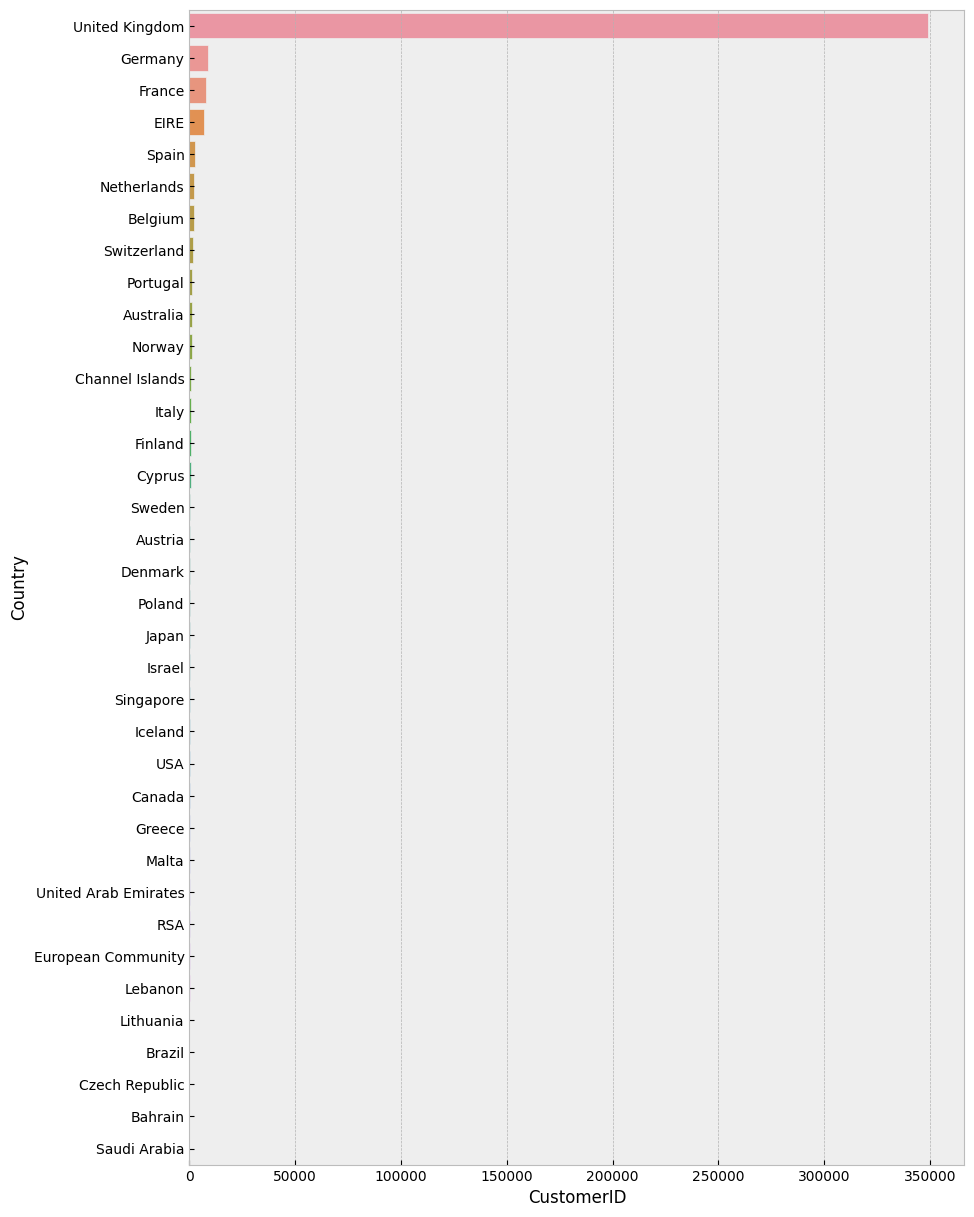

In [26]:
country_vc = df.groupby('Country', as_index=False)['CustomerID'].count()

plt.figure(figsize=(10, 15))
sns.barplot(country_vc.sort_values('CustomerID', ascending=False), 
            y='Country', 
            x='CustomerID', 
            orient='h')

> Несравнимое большинство покупок происходит в Великобритании, а остальные страны в сравнении с ней почти не вносят вклад в общую картину. Так что данный признак несет не так много информации о клиентах. 

#### 2.2.2 Какие страны приносят наибольшую выручку?

<AxesSubplot: xlabel='TotalPrice', ylabel='Country'>

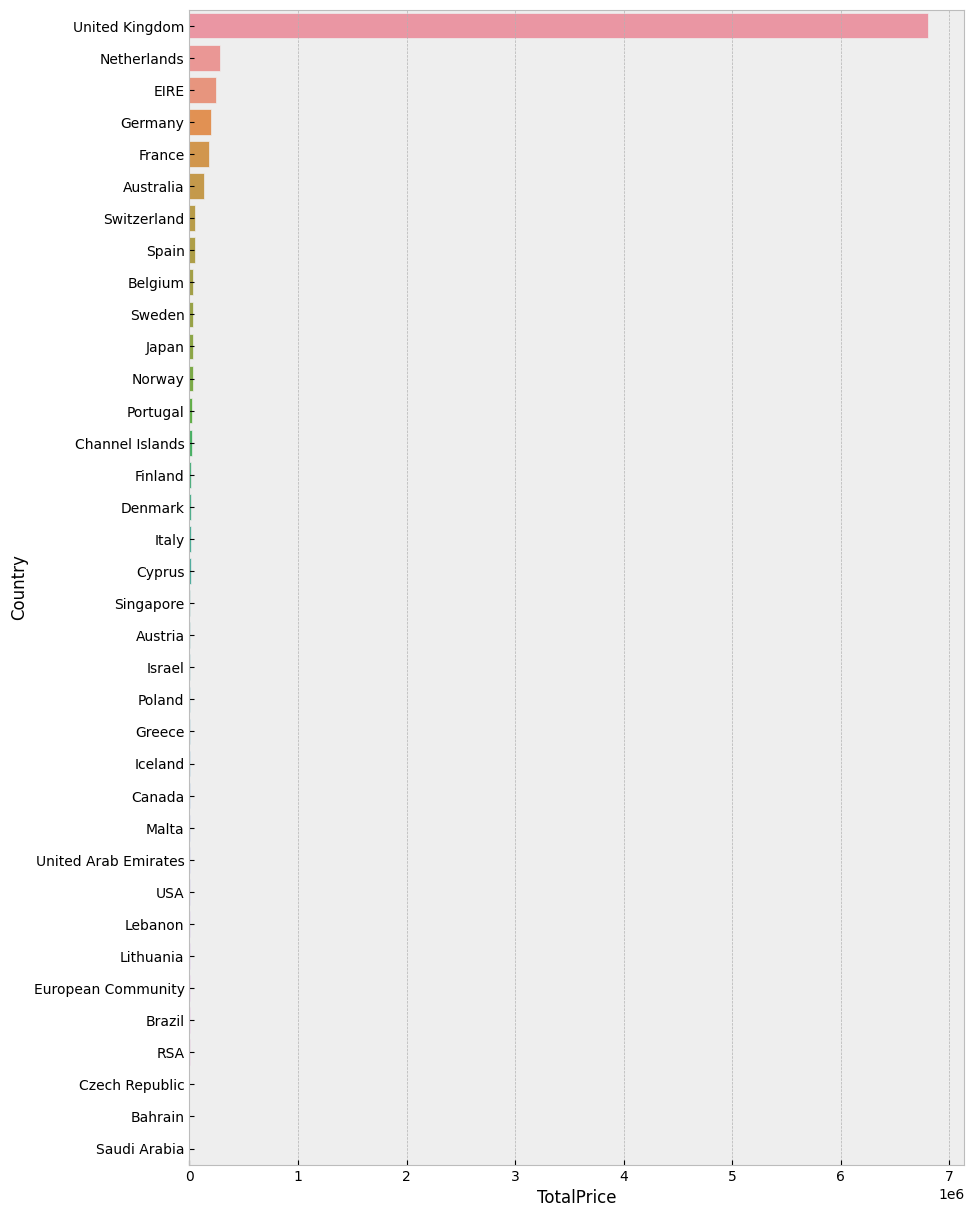

In [27]:
country_profit = df.groupby('Country', as_index=False)['TotalPrice'].sum()

plt.figure(figsize=(10, 15))
sns.barplot(country_profit.sort_values('TotalPrice', ascending=False), 
            y='Country', 
            x='TotalPrice', 
            orient='h') 

> Поскольку подавляющее большинство покупок совершается гражданами Великобритании, то логично, что и наибольшую выручку приносит именно эта страна. Это еще раз подтверждает, что столбец со странами несет мало информации о клиентах. 

#### 2.2.3 Присутствует ли в продажах сезонность?

<AxesSubplot: xlabel='Month', ylabel='TotalPrice'>

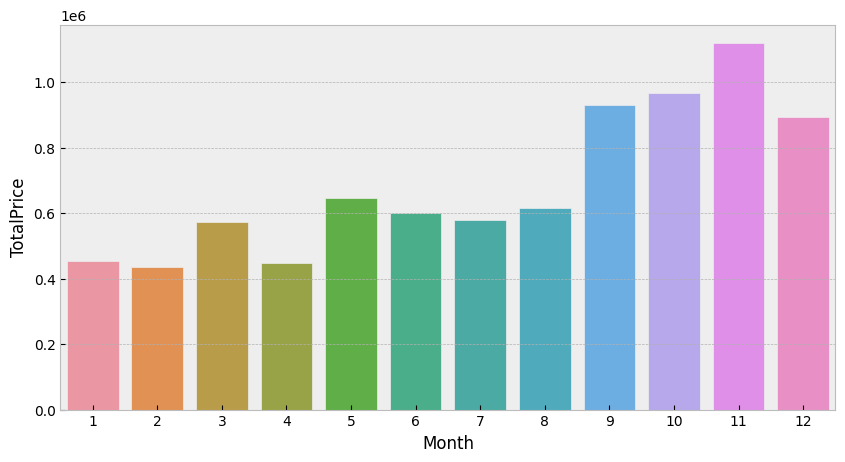

In [28]:
season_price = df.groupby('Month', as_index=False)['TotalPrice'].sum()

plt.figure(figsize=(10, 5))
sns.barplot(season_price, x='Month', y='TotalPrice')

> Можно проследить учащение покупок в конце года. Вероятно это связано с празднованием Хэллоуина и Рождества. При этом наблюдается резкое падение в первой половине года, когда большая часть денег уже потрачена в период праздников в прошлом году. Так что в данных определенно присутствует сезонность - с сентября по декабрь. 

#### 2.2.4 Каково распределение количества ежедневно поступающих заказов по дням месяца? 

<AxesSubplot: xlabel='CustomerID', ylabel='Density'>

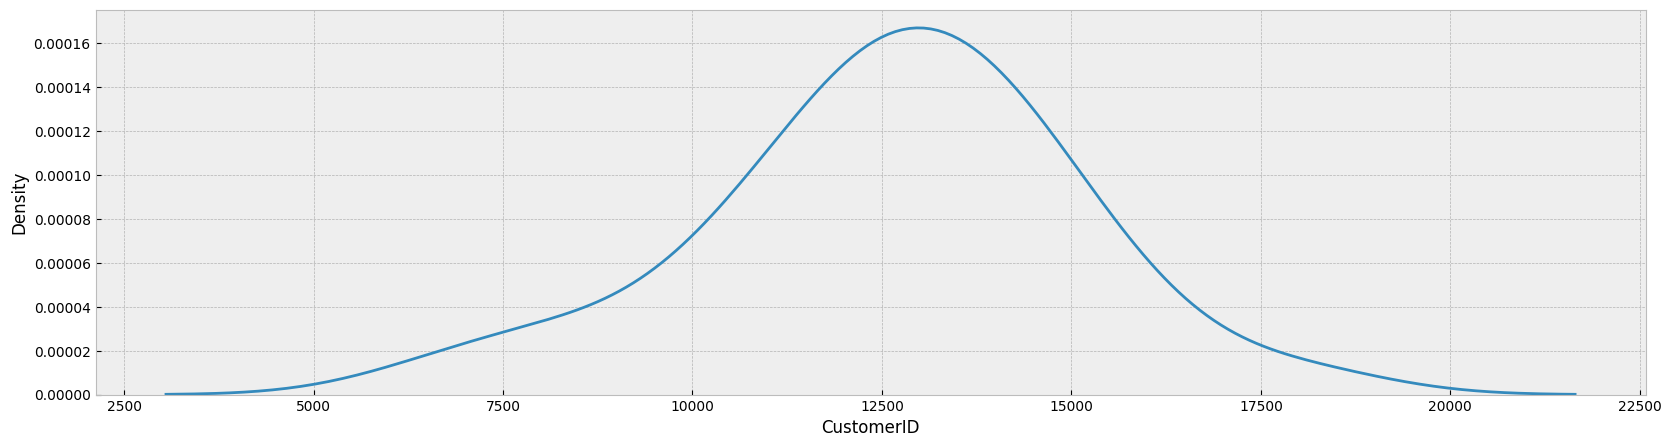

In [29]:
day_count = df.groupby('Day', as_index=False)['CustomerID'].count()

plt.figure(figsize=(20, 5))
sns.kdeplot(day_count, x='CustomerID')

> Распределение похоже на нормальное, однако это требует уточнения. Можно применить статистические тесты, например, тест Шапиро-Уилка.

In [30]:
def normality_test(x, h0, h1, alpha):
	"""Выводит на экран результат теста Шапиро-Уилка"""
	
	_, p = shapiro(x)
	print(f'p={round(p, 3)}')

	if p > alpha:
		print(h0)
	else:
		print(h1)


H0 = 'Данные распределены нормально'
H1 = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

normality_test(day_count['CustomerID'], 
               H0, 
               H1,
               alpha)

p=0.858
Данные распределены нормально


> Количество заказов по дням месяца имеют нормальное распределение. Это значит, что нет связи между днем месяца и количеством транзакций.

#### 2.2.5 Проверим то же самое по дням недели.

<AxesSubplot: xlabel='CustomerID', ylabel='Density'>

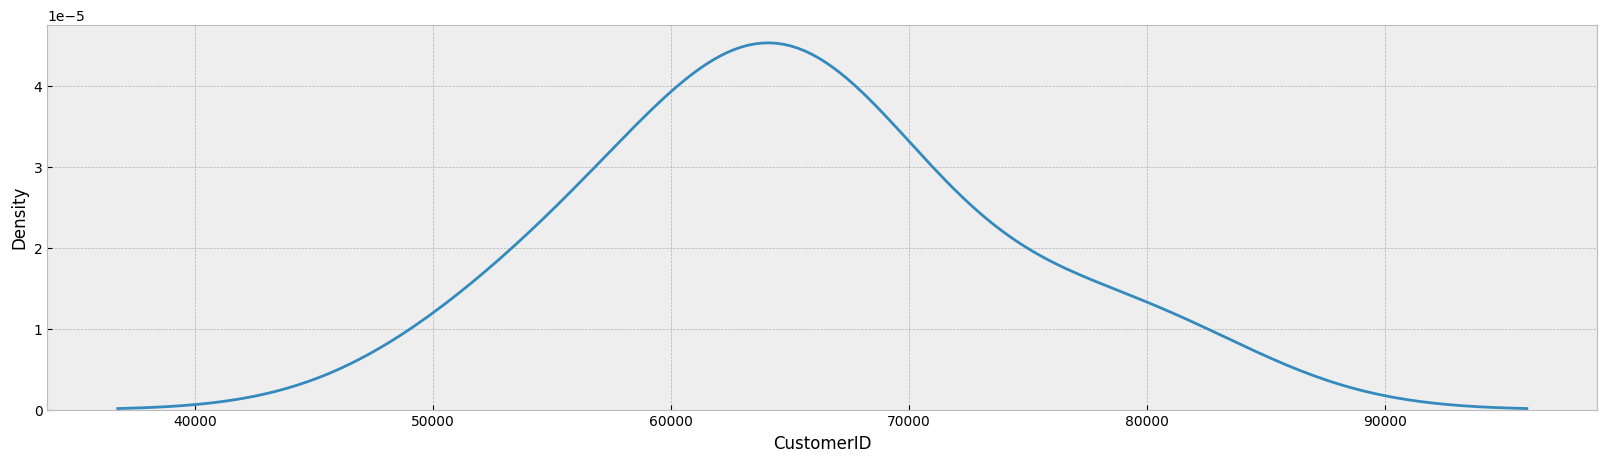

In [31]:
dayofweek_count = df.groupby('DayOfWeek', as_index=False)['CustomerID'].count()

plt.figure(figsize=(20, 5))
sns.kdeplot(dayofweek_count, x='CustomerID')

In [32]:
normality_test(dayofweek_count['CustomerID'], 
               H0, 
               H1,
               alpha)

p=0.83
Данные распределены нормально


> В отношении количества транзакций по дням недели данные также распределены нормально. Значит связи здесь тоже нет. 

#### 2.2.5 Какую долю выручки приносят частые и редкие клиенты? 

<AxesSubplot: xlabel='IsFrequentCustomer', ylabel='TotalPrice'>

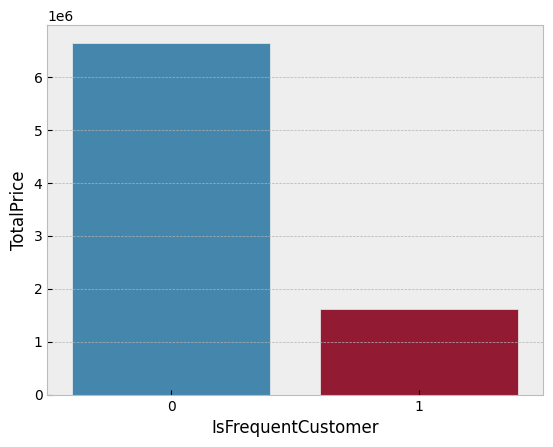

In [33]:
frequent_profit = df.groupby(['IsFrequentCustomer'], as_index=False)['TotalPrice'].sum()

sns.barplot(frequent_profit, x='IsFrequentCustomer', y='TotalPrice')

> Удивительно, но покупатели, которые делают заказы чаще обычного, приносят намного меньше прибыли, чем те, кто приходят в магазин реже. 

#### 2.2.6 Может частых клиентов просто не так много в данных?

<AxesSubplot: xlabel='IsFrequentCustomer', ylabel='CustomerID'>

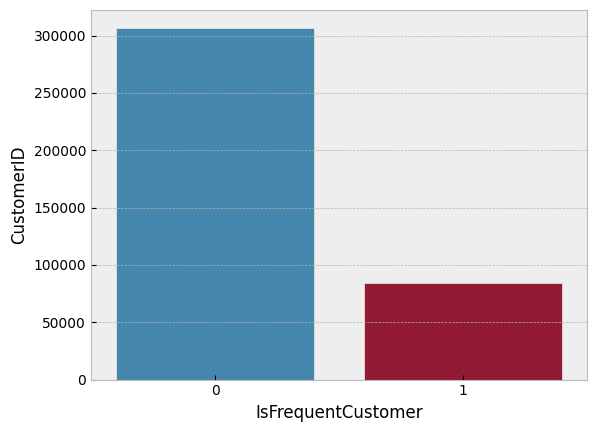

In [34]:
frequent_cust = df.groupby(['IsFrequentCustomer'], as_index=False)['CustomerID'].count()

sns.barplot(frequent_cust, x='IsFrequentCustomer', y='CustomerID')

> Действительно, частых клиентов в данных в принципе не много и суммарно их вклад не может превысить вклад всех остальных клиентов.

**Итоги разведывательного анализа:**
- Из стран наибольший вклад во всех отношениях вносит Великобритания.
- Больше всего покупок совершается в конце года, с сентября по декабрь.
- Количество заказов не зависит от дня месяца или недели.
- Частые клиенты вносят меньший вклад в общую картину, чем все остальные

### 2.3. Построение RFM-таблицы и поиск RFM-выбросов

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

In [35]:
t0 = pd.to_datetime('2011-12-10 00:00:00')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


# Группировка данных по идентификатору клиента
recency = df.groupby('CustomerID', as_index=False)['InvoiceDate'].last()
recency['InvoiceDate'] = (t0 - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID', as_index=False)['InvoiceDate'].count()

monetary_value = df.groupby('CustomerID', as_index=False)['TotalPrice'].sum()


# Соединение получившихся таблиц в одну
RFM_data = recency.rename(columns={'InvoiceDate': 'Recency'})

RFM_data = RFM_data.merge(frequency, 
                          on='CustomerID',
                          how='left').rename(columns={'InvoiceDate': 'Frequency'})

RFM_data = RFM_data.merge(monetary_value, 
                          on='CustomerID', 
                          how='left').rename(columns={'TotalPrice': 'MonetaryValue'})

RFM_data

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,325,1,0.00
1,12347.0,2,182,4310.00
2,12348.0,75,27,1437.24
3,12349.0,18,72,1457.55
4,12350.0,310,16,294.40
...,...,...,...,...
4325,18280.0,277,10,180.60
4326,18281.0,180,7,80.82
4327,18282.0,7,12,176.60
4328,18283.0,3,719,2039.58


<AxesSubplot: xlabel='MonetaryValue'>

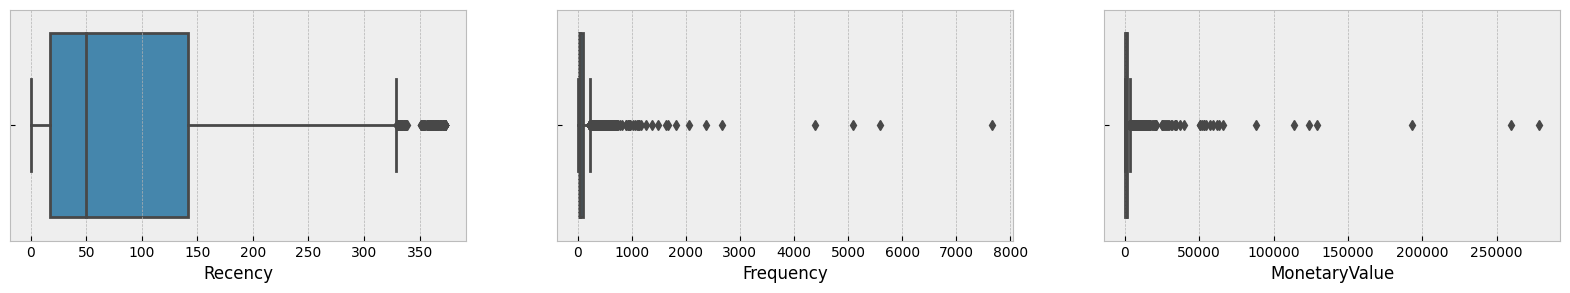

In [36]:
# Визуализируем каждую из трёх компонент в виде коробчатых диаграмм 
fig, ax = plt.subplots(1, 3, figsize=(20, 3))

sns.boxplot(RFM_data, x='Recency', ax=ax[0])
sns.boxplot(RFM_data, x='Frequency', ax=ax[1])
sns.boxplot(RFM_data, x='MonetaryValue', ax=ax[2]) 

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


<AxesSubplot: xlabel='MonetaryValue'>

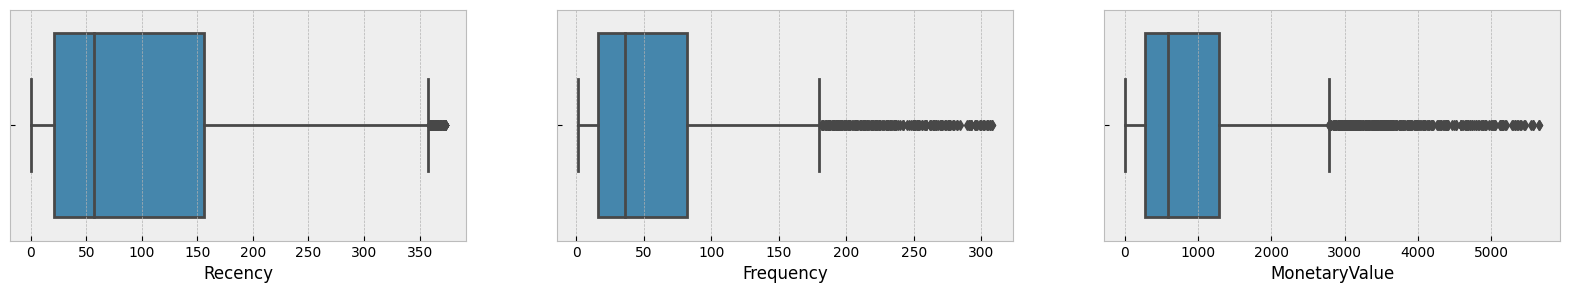

In [37]:
freq_95 = RFM_data['Frequency'].quantile(0.95)
monv_95 = RFM_data['MonetaryValue'].quantile(0.95)

RFM_data = RFM_data[(RFM_data['Frequency'] <= freq_95) & 
                    (RFM_data['MonetaryValue'] <= monv_95)]

fig, ax = plt.subplots(1, 3, figsize=(20, 3))

sns.boxplot(RFM_data, x='Recency', ax=ax[0])
sns.boxplot(RFM_data, x='Frequency', ax=ax[1])
sns.boxplot(RFM_data, x='MonetaryValue', ax=ax[2])

> Теперь другое дело.

## 3. Моделирование и оценка качества моделей

### 3.1. Кластеризация на основе RFM-характеристик

Чтобы методы понижения размерности работали стабильно, данные необходимо стандартизировать. 

На основе RFM-признаков произведем кластеризацию клиентов онлайн-магазина подарков с помощью известных нам методов. Я решил использовать *метод К-средних*, *EM-кластеризацию* и *Аггломеративную Иерархическую кластеризацию*.

Подберем оптимальное количество кластеров для выбранных методов с помощью коэффициента силуэта, перебирая возможные значения от 3 до 10 включительно (большее или меньшее количество будет нерелеватно для маркетинга). Для этого я создал специальную функцию.

После всего этого я выберу алгоритм с наибольшим коэффициентом силуэта и сделаю предсказание меток кластеров.

In [38]:
# Стандартизация понадобится только для самой кластеризации, 
# так что создадим отдельную таблицу с обработанными признаками
scaler = StandardScaler()

cols = ['Recency', 'Frequency', 'MonetaryValue']

RFM_std = RFM_data[cols].copy()
RFM_std = scaler.fit_transform(RFM_data[cols])

RFM_std

array([[ 2.23515958, -0.94569121, -0.93912415],
       [-0.94750327,  2.01115797,  3.23965099],
       [-0.22820176, -0.52095044,  0.45435678],
       ...,
       [ 0.80641   , -0.84767411, -0.86076484],
       [-0.89823604, -0.76599319, -0.76790102],
       [-0.55336545,  0.18150544,  0.84221692]])

In [39]:
def clustering_optimisation(X, algorithm, RS=42, plot=False):
    """Функция подбирает различные значения количества кластеров для
    указанного алгоритма кластеризации, производит подсчет 
    коэффициента силуэта, заносит в соответствующий словарь пару 
    "число кластеров - значение коэффициента", и возвращает либо график
    изменения КС в зависимости от числа кластеров, либо сам словарь.
    
    Args:
    -
        X (DataFrame): данные для подбора количества кластеров \n
        algorithm (str): алгоритм кластеризации \n
        RS (int): параметр для `random_state` \n
        plot (bool): возвращать ли график, если нет - вернуть словарь
    """
    
    scores = {}
    
    for i in range(3, 11):
        if algorithm == 'kmeans':
            model = KMeans(n_clusters=i, n_init=10, random_state=RS)
        elif algorithm == 'agglomerative':
            model = AgglomerativeClustering(n_clusters=i)
        elif algorithm == 'EM':
            model = GaussianMixture(n_components=i, random_state=RS)
        
        y = model.fit_predict(X)
        
        scores[i] = silhouette_score(X, y, random_state=RS)
        
    if plot:
        plt.xlabel("cluster", fontsize=12)
        plt.ylabel("silhouette", fontsize=12)
        plt.title(f"silhouette_score: {algorithm}", fontsize=12)

        plt.plot(list(scores.keys()), 
                 list(scores.values()), 
                 'xb-')
    else:
        return scores

#### 3.1.1 KMeans

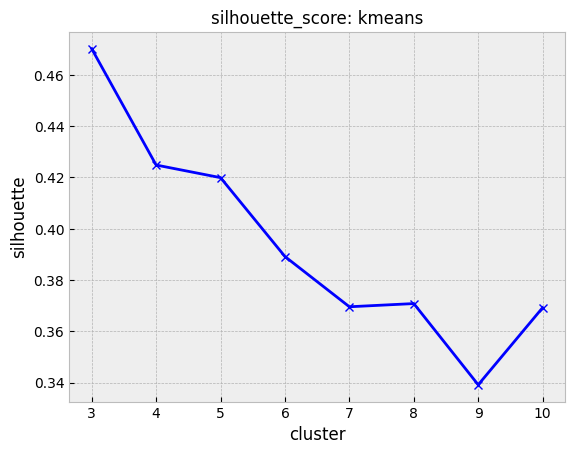

In [40]:
clustering_optimisation(RFM_std, 'kmeans', plot=True)

#### 3.1.2 EM-кластеризация

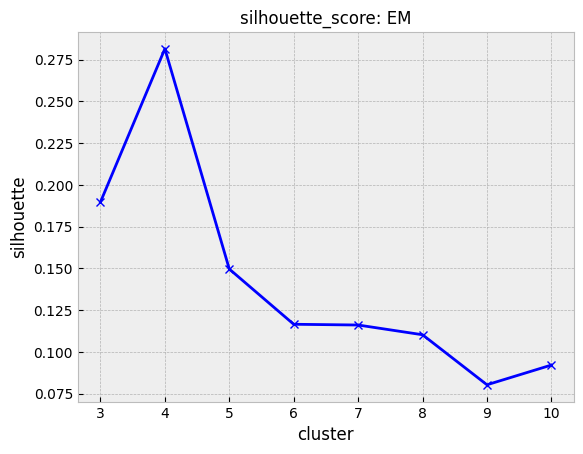

In [41]:
clustering_optimisation(RFM_std, 'EM', plot=True)

#### 3.1.3 Аггломеративная Иерархичесткая кластеризация

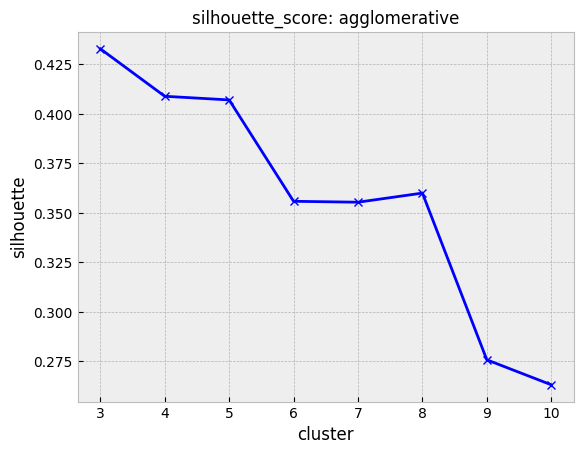

In [42]:
clustering_optimisation(RFM_std, 'agglomerative', plot=True)

> Большинство алгоритмов, судя по значениям коэффициента силуэта, указывают оптимальное количество кластеров - 3. Также наилучшим образом себя показал самый обычный KMeans, так как его КС на отметке в 3 кластера самый высокий. Попробуем еще немного другой метод - DBSCAN. 

#### 3.1.4 DBSCAN

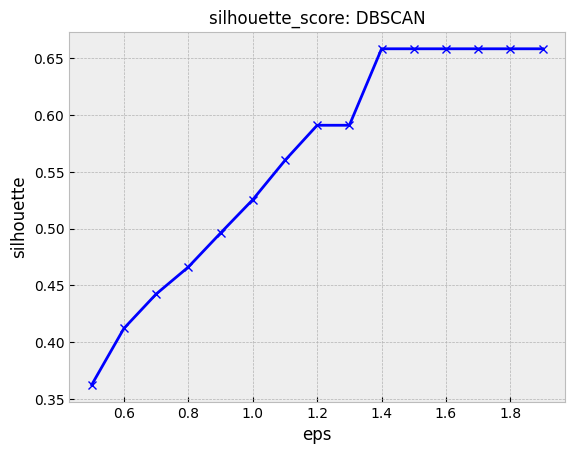

In [43]:
scores = {}

for i in np.arange(0.5, 2, 0.1):
    model = DBSCAN(eps=i)
    y = model.fit_predict(RFM_std)
    
    scores[i] = silhouette_score(RFM_std, y, random_state=42)
    

plt.xlabel("eps", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.title("silhouette_score: DBSCAN", fontsize=12)

plt.plot(list(scores.keys()), 
            list(scores.values()), 
            'xb-')

In [44]:
model = DBSCAN(eps=1.4)
RFM_data['Label_DBSCAN'] = model.fit_predict(RFM_std) + 1

RFM_data['Label_DBSCAN'].unique()

array([1, 0], dtype=int64)

> Алгоритм DBSCAN с параметром радиуса, равным 1.4, определил оптимальное количество кластеров как 2. Сохраним результаты в отдельный столбец.

In [45]:
# Занесем резултат работы KMeans в свой столбец

model = KMeans(n_clusters=3, n_init=10, random_state=42)
RFM_data['Label_KMeans'] = model.fit_predict(RFM_std)

RFM_data

,CustomerID,Recency,Frequency,MonetaryValue,Label_DBSCAN,Label_KMeans
0,12346.0,325,1,0.00,1,1
1,12347.0,2,182,4310.00,1,2
2,12348.0,75,27,1437.24,1,0
3,12349.0,18,72,1457.55,1,0
4,12350.0,310,16,294.40,1,1
...,...,...,...,...,...,...
4324,18278.0,73,9,173.90,1,0
4325,18280.0,277,10,180.60,1,1
4326,18281.0,180,7,80.82,1,1
4327,18282.0,7,12,176.60,1,0


### 3.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

#### 3.2.1. 3D-визуализация кластеров

Визуализируем результаты в виде 3D-диаграммы с осями 'Recency', 'Frequency' и 'MonetaryValue'. Попробуем понять, какие кластеры у нас получились.

In [46]:
def make_scatter3d(data, labels):
    """Функция создает трехмерную точечную диаграмму, 
    окрашенную в зависимости от целевой переменной.
    
    Args:
    -
        data (DataFrame): таблица c данными - X \n
        labels (Series): целевой признак - y
    
    """
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(projection='3d') 
    
    # Название целевого признака
    y = 'Label_' + labels
    
    # Создаем трехмерную точечную диаграмму
    scat = ax.scatter(xs=data['Recency'], 
                      ys=data['Frequency'], 
                      zs=data['MonetaryValue'], 
                      c=data[y])
    
    # Названия осей и самого графика
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('MonetaryValue')
    ax.set_title(f'Распределение кластеров в трехмерном пространстве ({labels})')

    # Легенда
    legend = ax.legend(scat.legend_elements()[0], 
                    [0, 1, 2], 
                    title="Label", 
                    loc='upper right')
    ax.add_artist(legend)

    fig.show()

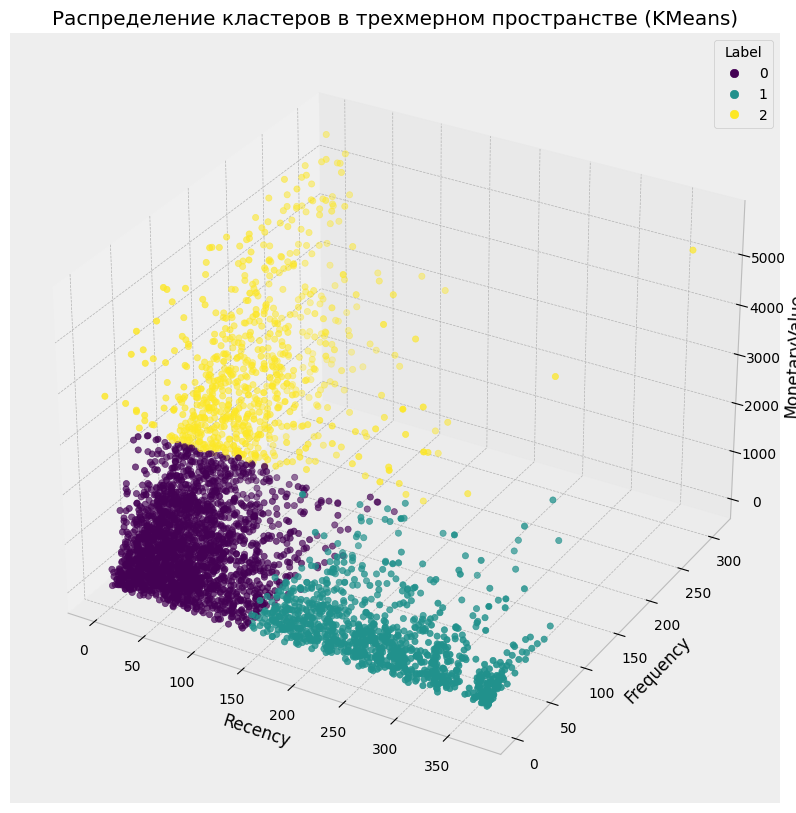

In [47]:
make_scatter3d(RFM_data, 'KMeans')

> У нас получился красивый, аккуратный график с четким разделением на 3 кластера! Попробуем примерно обозначить их границы и интерпретировать их.

- *Кластер 0* - не более чем 100 заказов, не ранее 130 дней назад и не дороже 2000 фунтов - условные **БЕДНЫЕ НОВИЧКИ**.
- *Кластер 1* - разное количество заказов более 130 дней назад на сумму до 1000 фунтов - условные **БЕДНЫЕ СПЯЩИЕ**.
- *Кластер 2* - более 100 заказов на сумму более 2000 фунтов в разное время - условные **БОГАТЫЕ ЛОЯЛЬНЫЕ**.

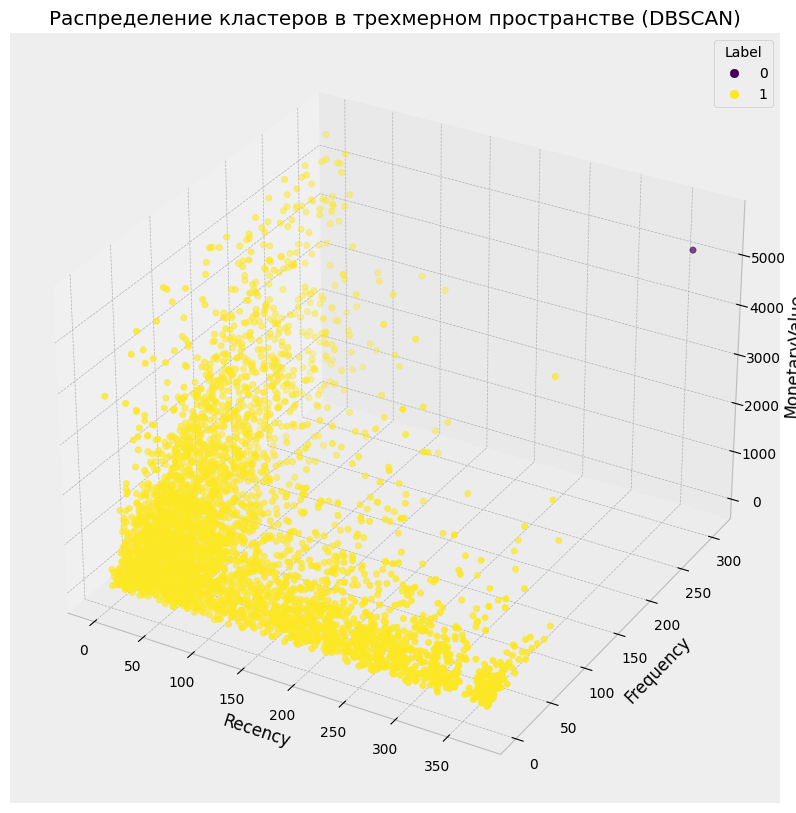

In [48]:
# Проверим, как с кластеризацией справился DBSCAN
make_scatter3d(RFM_data, 'DBSCAN')

> Оказывается, он все данные записал в один кластер и нашел единственный выброс. Не думаю, что этот алгоритм дает нам много пользы.

In [49]:
# Избавимся от ненужного столбца
RFM_data.drop('Label_DBSCAN', axis=1, inplace=True)

#### 3.2.2 Профиль кластеров

Теперь составим так называемый профиль кластеров.

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум.

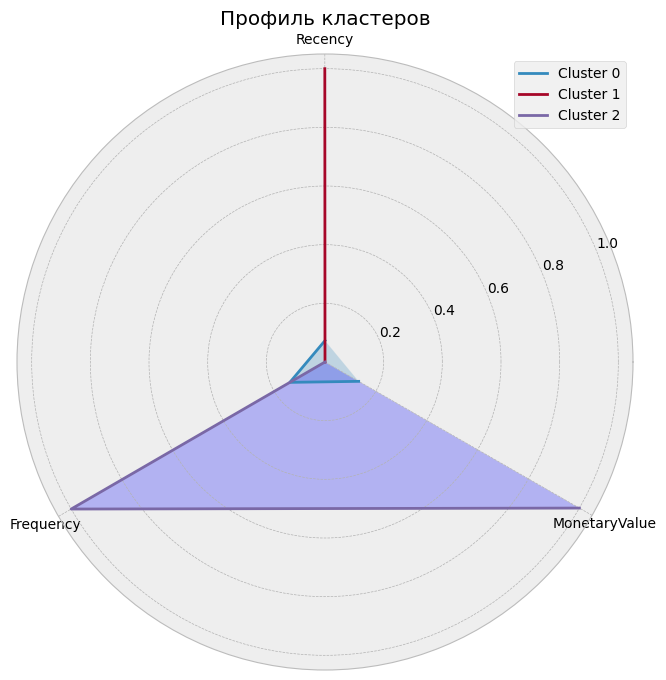

In [50]:
# Создаем полярную диаграмму
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)

# Делаем так, чтобы оси Х делили окружность на 3 равные части
pi = 22/7
angles = [pi/2, 7*pi/6, 11*pi/6]
plt.xticks(angles, cols)

# Группируем данные по кластерам и вычисляем среднее по RFM-признакам
RFM_groupped = RFM_data.groupby('Label_KMeans', as_index=False)[cols].mean()

# Нормализуем сгруппированные данные, приводя их к масштабу 0-1
scaler = MinMaxScaler()
RFM_scaled = pd.DataFrame(scaler.fit_transform(RFM_groupped), 
                          columns=RFM_groupped.columns)

# Строим 3 графика по трем кластерам
values = RFM_scaled[cols].iloc[0]
ax.plot(angles, values, linewidth=2, label='Cluster 0')
ax.fill(angles, values, 'p', alpha=0.25)

values = RFM_scaled[cols].iloc[1]
ax.plot(angles, values, linewidth=2, label='Cluster 1')
ax.fill(angles, values, 'r', alpha=0.25)

values = RFM_scaled[cols].iloc[2]
ax.plot(angles, values, linewidth=2, label='Cluster 2')
ax.fill(angles, values, 'b', alpha=0.25)

ax.set_title('Профиль кластеров')

# Выводим легенду и сам график
plt.legend()
plt.show()

> Группа **БЕДНЫЕ НОВИЧКИ** не делают значительного вклада в данные и имеют одинаково малые показатели по всем 3 осям. Группа **БЕДНЫЕ СПЯЩИЕ** делали заказы очень давно, но не часто и не принесли значительной прибыли магазину. А группа **БОГАТЫЕ ЛОЯЛЬНЫЕ** делают заказы часто и тратят много денег. 

## 4. Выводы и оформление работы

> В результате проделанной работы было выявленно **3** категории покупателей нашего онлайн-магазина, подробно описанные в предыдущих пометках, а также в файле README. Работу считаю завершенной. 

In [51]:
# Сохраним полученный результат в общую таблицу в формате .csv
data_complete = df.merge(RFM_data, on='CustomerID', how='left')

data_complete.to_csv('data/pj6_data_complete.csv', index=False)

data_complete

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,IsFrequentCustomer,Month,Day,DayOfWeek,IsFrequentStock,Recency,Frequency,MonetaryValue,Label_KMeans
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0.0,15.30,0,12,1,2,1,372.0,297.0,5322.84,2.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,0,12,1,2,1,372.0,297.0,5322.84,2.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0.0,22.00,0,12,1,2,1,372.0,297.0,5322.84,2.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,0,12,1,2,0,372.0,297.0,5322.84,2.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,0,12,1,2,1,372.0,297.0,5322.84,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0.0,10.20,0,12,9,4,1,0.0,49.0,790.81,0.0
390905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0.0,12.60,0,12,9,4,0,0.0,49.0,790.81,0.0
390906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60,0,12,9,4,0,0.0,49.0,790.81,0.0
390907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0.0,16.60,0,12,9,4,0,0.0,49.0,790.81,0.0
